# Project 2: Data Representations and Clustering

Wenxin Cheng	706070535    wenxin0319@g.ucla.edu

Yuxin Yin		606073780    yyxyy999@g.ucla.edu

Yingqian Zhao	306071513    zhaoyq99@g.ucla.edu

## 0 pre-install packages

In [1]:
# !pip install nltk
# !pip install sklearn
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install scikit-learn
# !pip install seaborn
# !pip install umap-learn
# !pip install umap-learn[plot]
# !pip install annoy==1.17.0
# !pip install cython==0.29.21
# !pip install fuzzywuzzy==0.18.0
# !pip install hdbscan==0.8.26
# !pip install joblib==1.0.0
# !pip install kiwisolver==1.3.1
# !pip install llvmlite==0.35.0
# !pip install matplotlib==3.3.2
# !pip install numba==0.52.0
# !pip install pandas==1.1.2
# !pip install pillow==8.1.0
# !pip install pyarrow==1.0.1
# !pip install python-levenshtein==0.12.1
# !pip install pytz==2021.1
# !pip install scikit-learn==0.24.1
# !pip install scipy==1.6.0
# !pip install six==1.15.0
# !pip install threadpoolctl==2.1.0
# !pip install tqdm==4.50.0
# !pip install torch

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Question 1

In [12]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import random
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import contingency_matrix
from collections import defaultdict
from sklearn import metrics
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF
from tqdm import tqdm, trange
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import umap.plot as uplot
import umap.umap_ as umap
from sklearn.model_selection import train_test_split 
import hdbscan
from sklearn.manifold import TSNE
import seaborn as sns
import pickle
import os
import requests
import torch
from torch import nn

np.random.seed(0)
random.seed(0)


In [4]:
categories = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
dataset = fetch_20newsgroups(subset = 'all', categories = categories,shuffle = True, random_state = 0,remove=('headers','footers'))

In [5]:
dataset.target 

array([6, 4, 1, ..., 0, 4, 6], dtype=int64)

In [6]:
dataset.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [7]:
labels = dataset.target
unique_Y_binary, category_sizes = np.unique(dataset.target, return_counts=True)
true_k = len(unique_Y_binary)
print(f"{len(dataset.data)} documents - {true_k} categories")

7882 documents - 8 categories


In [8]:
dataset.target_names

['comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey']

In [5]:
comp_class = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware']
rec_class = ['rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']

In [6]:
Y_binary = [i // 4 for i in dataset.target]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vectorizer = CountVectorizer(stop_words="english", min_df=3)
tfidf_tranformer = TfidfTransformer(use_idf=True)

data_count_vectorizer = count_vectorizer.fit_transform(dataset.data)
print(f"n_samples: {data_count_vectorizer .shape[0]}, n_features: {data_count_vectorizer.shape[1]}")

data_tf_idf3 = tfidf_tranformer.fit_transform(data_count_vectorizer)
data_tf_idf3_ar = data_tf_idf3.toarray()
print('data tf-idf matrix shape:', data_tf_idf3_ar.shape)

dataset_pd = pd.DataFrame(data=data_tf_idf3_ar , columns = count_vectorizer.get_feature_names_out())

n_samples: 7882, n_features: 23522
data tf-idf matrix shape: (7882, 23522)


### Question 2

In [8]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(dataset_pd)

KMeans(max_iter=1000, n_clusters=2, n_init=30, random_state=0)

In [9]:
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def plot_mat(mat, xticklabels = None, yticklabels = None, pic_fname = None, size=(-1,-1), if_show_values = True,
             colorbar = True, grid = 'k', xlabel = None, ylabel = None, title = None, vmin=None, vmax=None):
    if size == (-1, -1):
        size = (mat.shape[1] / 3, mat.shape[0] / 3)

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)

    # im = ax.imshow(mat, cmap=plt.cm.Blues)
    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid, vmin=vmin, vmax=vmax)
    
    if colorbar:
        plt.colorbar(im,fraction=0.046, pad=0.06)
    # tick_marks = np.arange(len(classes))
    # Ticks
    lda_num_topics = mat.shape[0]
    nmf_num_topics = mat.shape[1]
    yticks = np.arange(lda_num_topics)
    xticks = np.arange(nmf_num_topics)
    ax.set_xticks(xticks + 0.5)
    ax.set_yticks(yticks + 0.5)
    if xticklabels is None:
        xticklabels = [str(i) for i in xticks]
    if yticklabels is None:
        yticklabels = [str(i) for i in yticks]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    # Minor ticks
    # ax.set_xticks(xticks, minor=True);
    # ax.set_yticks(yticks, minor=True);
    # ax.set_xticklabels([], minor=True)
    # ax.set_yticklabels([], minor=True)

    # ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

    # tick labels on all four sides
    ax.tick_params(labelright = True, labeltop = False)

    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=15)
    if title:
        plt.title(title, fontsize=15)

    # im = ax.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.invert_yaxis()

    # thresh = mat.max() / 2

    def show_values(pc, fmt="%.0f", **kw):
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, value in itertools.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw, fontsize=10)

    if if_show_values:
        show_values(im)
    # for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    #     ax.text(j, i, "{:.2f}".format(mat[i, j]), fontsize = 4,
    #              horizontalalignment="right",
    #              color="white" if mat[i, j] > 0.05 else "black")

    plt.tight_layout()
    if pic_fname:
        plt.savefig(pic_fname, dpi=300, transparent=True)
    plt.show()
    plt.close()

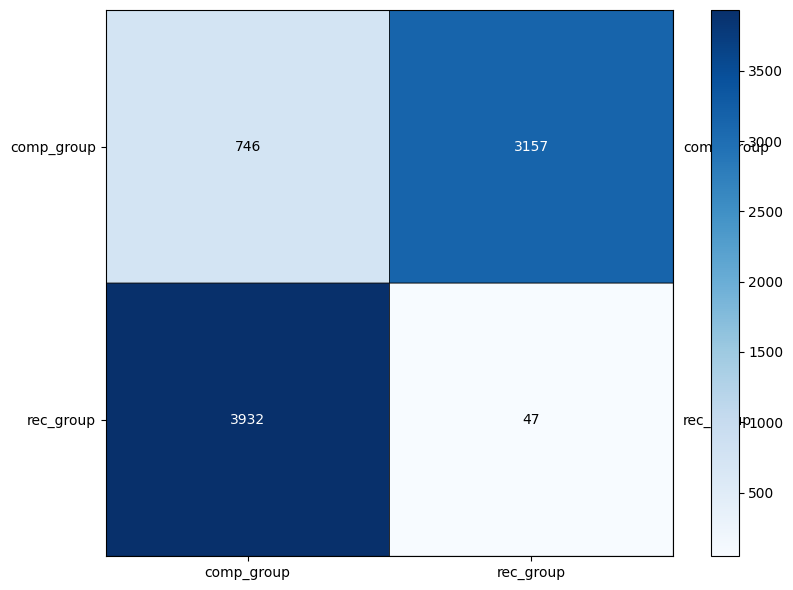

In [10]:
from sklearn.metrics.cluster import contingency_matrix

plot_mat(contingency_matrix(Y_binary, kmeans.labels_), size = (8,6), xticklabels = ['comp_group','rec_group'],yticklabels =['comp_group','rec_group'])

### Question 3

In [27]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []

def evaluate(km, X, Y_binary, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        t0 = time()
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(Y_binary, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(Y_binary, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(Y_binary, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(Y_binary, km.labels_)
        )
        scores["Adjusted_mutual_info_score"].append(
            adjusted_mutual_info_score(Y_binary, km.labels_)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [28]:
evaluate(kmeans, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")

clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.579 ± 0.000
Completeness: 0.594 ± 0.000
V-measure: 0.587 ± 0.000
Adjusted Rand-Index: 0.638 ± 0.000
Adjusted_mutual_info_score: 0.587 ± 0.000


### Question 4

In [17]:
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm, trange

k = [1, 10, 50, 100, 200, 500, 1000]
explained_variance_ratio = []

def plot_figure_for_each_k(k, svd_t):
    exp_var_pca = svd_t.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.title(f"Explained_variance_ratio when k = {k}")
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()    


for i in trange(len(k)):
    svd_t = TruncatedSVD(n_components=k[i], random_state=42)
    svd_t.fit(data_tf_idf3)
    # plot_figure_for_each_k(kcomponents[i], svd_t)
    explained_variance_ratio.append(sum(svd_t.explained_variance_ratio_))

100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


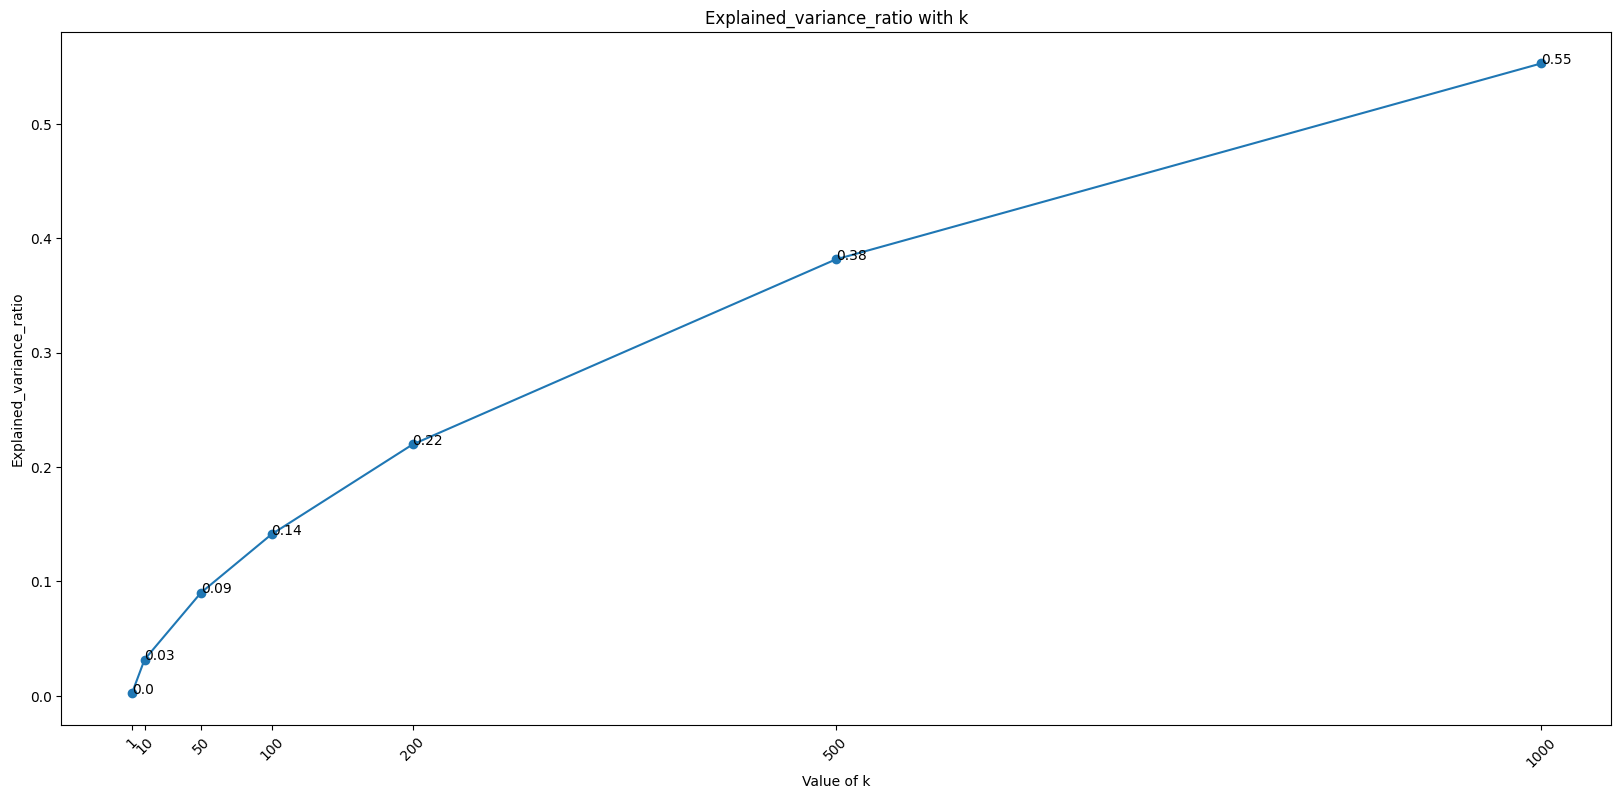

In [18]:
plt.figure(figsize=(20,9))   
plt.title('Explained_variance_ratio with k')
plt.xlabel("Value of k")
plt.ylabel("Explained_variance_ratio")

plt.xticks(k, rotation = 45)    

plt.plot(k, explained_variance_ratio, ls="-", marker="o", label="points")

for ks, exp in zip(k, explained_variance_ratio):
      plt.text(ks, exp, str(round(exp, 2)))
plt.show()

### Question 5

In [34]:
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm, trange

r_ = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
SVD_results = defaultdict(list)
NMF_results = defaultdict(list)

best_svd = 0
best_nmf = 0
best_svd_r = 0
best_nmf_r = 0

for r in r_:
    print('n_componets: ' + str(r))

    model_svd = TruncatedSVD(n_components=r)
    svd_data = model_svd.fit_transform(data_tf_idf3)
    km = KMeans(n_clusters=2, random_state=0)
    km.fit(svd_data)

    SVD_results["Homogeneity"].append(metrics.homogeneity_score(Y_binary, km.labels_))
    SVD_results["Completeness"].append(metrics.completeness_score(Y_binary, km.labels_))
    SVD_results["V-measure"].append(metrics.v_measure_score(Y_binary, km.labels_))
    SVD_results["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(Y_binary, km.labels_))
    SVD_results["Adjusted_mutual_info_score"].append(adjusted_mutual_info_score(Y_binary, km.labels_))
   
    avg_svd_score = (SVD_results["Homogeneity"][-1] + SVD_results["Completeness"][-1] \
    + SVD_results["V-measure"][-1] + SVD_results["Adjusted Rand-Index"][-1]  \
    + SVD_results["Adjusted_mutual_info_score"][-1]) / 5.0

    if(avg_svd_score > best_svd):
        best_svd = avg_svd_score
        best_svd_r = r
        best_svd_kmeans = km
        best_svd_data = svd_data

    model_nmf = NMF(n_components=r)
    nmf_data = model_nmf.fit_transform(data_tf_idf3)
    km = KMeans(n_clusters=2, random_state=0)
    km.fit(nmf_data)

    NMF_results["Homogeneity"].append(metrics.homogeneity_score(Y_binary, km.labels_))
    NMF_results["Completeness"].append(metrics.completeness_score(Y_binary, km.labels_))
    NMF_results["V-measure"].append(metrics.v_measure_score(Y_binary, km.labels_))
    NMF_results["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(Y_binary, km.labels_))
    NMF_results["Adjusted_mutual_info_score"].append(adjusted_mutual_info_score(Y_binary, km.labels_))

    avg_nmf_score = (NMF_results["Homogeneity"][-1] + NMF_results["Completeness"][-1] \
    + NMF_results["V-measure"][-1] + NMF_results["Adjusted Rand-Index"][-1]  \
    + NMF_results["Adjusted_mutual_info_score"][-1]) / 5.0

    if(avg_nmf_score > best_nmf):
        best_nmf = avg_nmf_score 
        best_nmf_r = r
        best_nmf_kmeans = km
        best_nmf_data = nmf_data


print(f"best r for svd is {best_svd_r}, the average score is: {best_svd:.3f}")
print(f"best r for nmf is {best_nmf_r}, the average score is: {best_nmf:.3f}")

n_componets: 1
n_componets: 2
n_componets: 3
n_componets: 4
n_componets: 5
n_componets: 6
n_componets: 7
n_componets: 8
n_componets: 9
n_componets: 10
n_componets: 20
n_componets: 50
n_componets: 100
n_componets: 300
best r for svd is 100, the average score is: 0.595
best r for nmf is 2, the average score is: 0.614


In [32]:
def plot_measure(results, r_, model_name):
  results_df = pd.DataFrame(
      data = results,
      index = r_
  )

  results_df.plot(
      kind = 'bar',
      title = "{}: Measure Scores Based on Different Ks".format(model_name), 
      xlabel = "Different Ks",
      ylabel = "The Measure Score",
      figsize = (12, 7)
  )

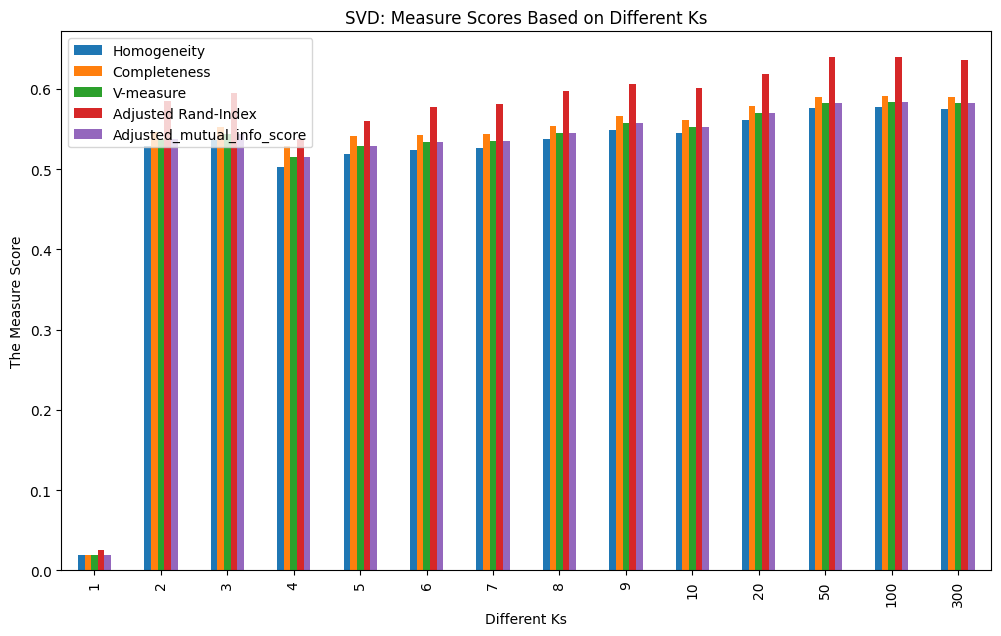

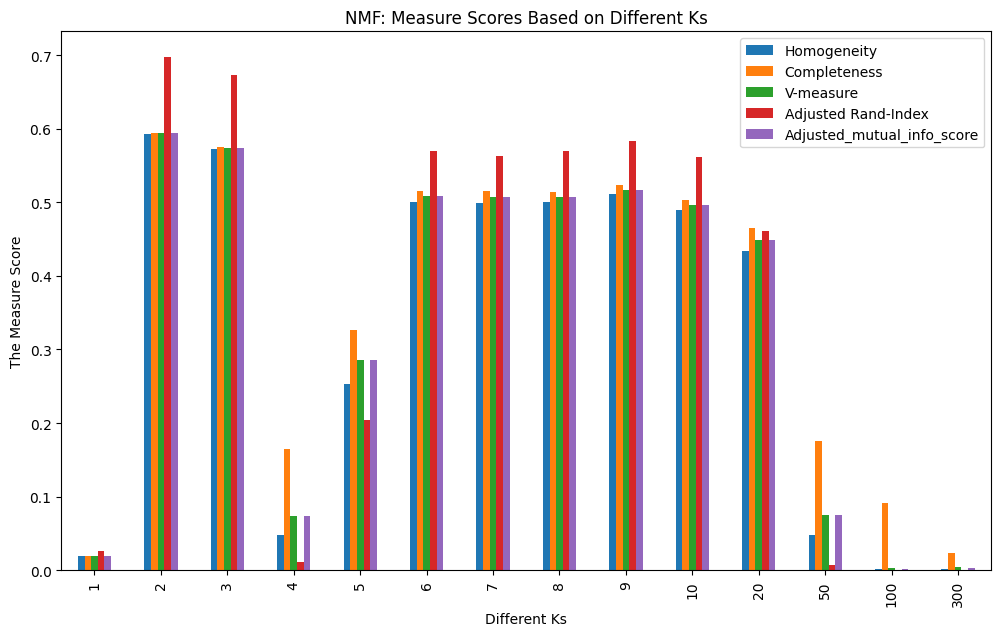

In [35]:
plot_measure(SVD_results, r_, "SVD")
plot_measure(NMF_results, r_, "NMF")

### Question6 and Question 7 are stated on our Report
### Question8

In [22]:
def plot_kmeans_clusters(km, data, truth, model_name):

  fig = plt.figure(figsize=(12, 6))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)

  predicted_labels = km.labels_
  if np.mean(km.labels_ == truth) > 0.5:
    predicted_labels = km.labels_
  else:
    predicted_labels = [1-x for x in km.labels_]
  ax1.scatter(
      x = data[: ,0],
      y = data[: ,1],
      c = predicted_labels, 
      edgecolors='k', 
      linewidth=0.25,  
      cmap='cool', 
      alpha=0.5
  )
  ax1.set_title("Prediction")

  ax2.scatter(
      x = data[: ,0],
      y = data[: ,1],
      c = truth,
      edgecolors='k', 
      linewidth=0.25,  
      cmap='cool', 
      alpha=0.5
  )
  ax2.set_title("Ground Truth")
  fig.suptitle("Best {} Visualization".format(model_name))
  plt.show()

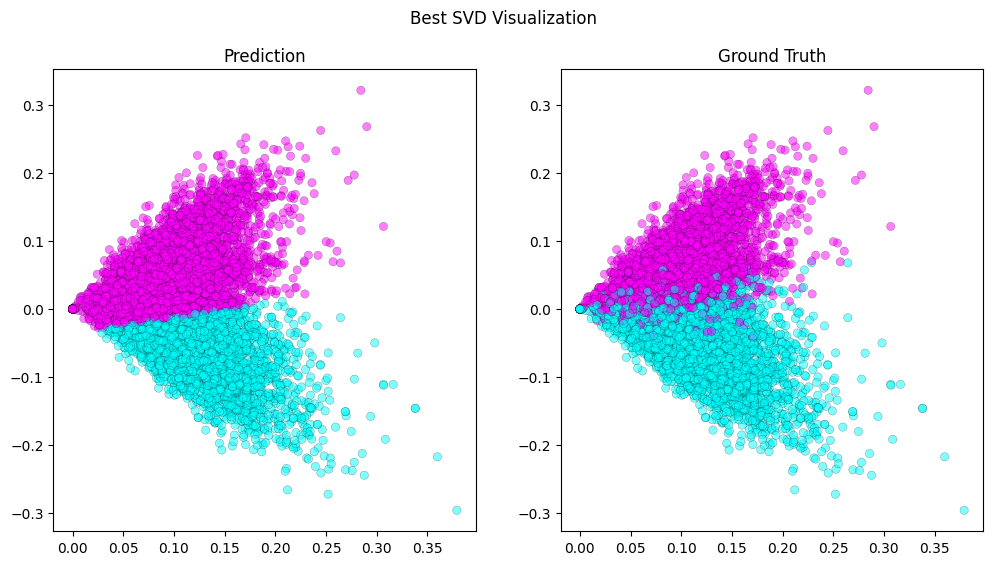

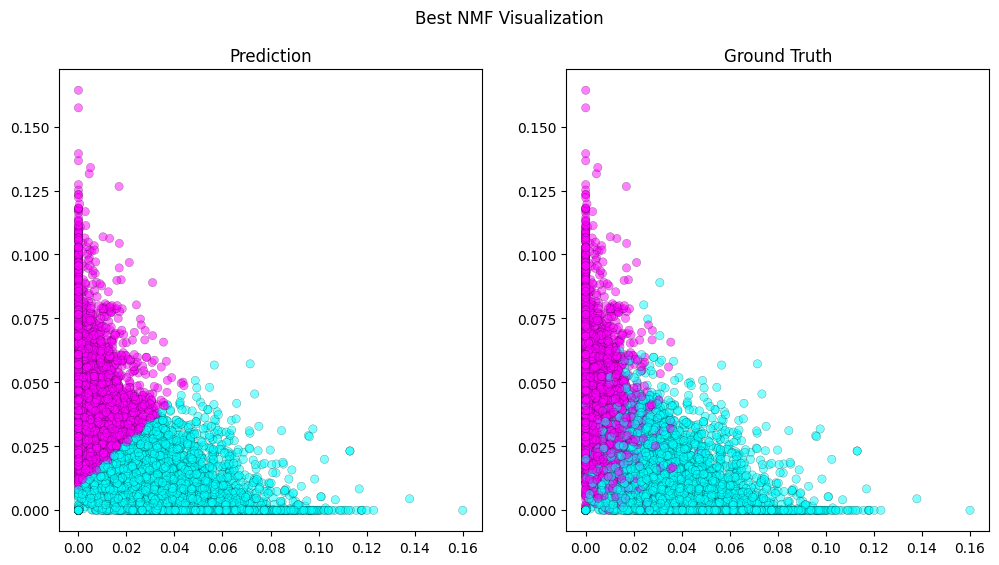

In [23]:
plot_kmeans_clusters(best_svd_kmeans, best_svd_data, Y_binary, "SVD")
plot_kmeans_clusters(best_nmf_kmeans, best_nmf_data, Y_binary, "NMF")

### Question9 is stated on our Report
### Question10

In [46]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

dataset = fetch_20newsgroups(subset = 'all', shuffle = True, random_state = 0,remove=('headers','footers'))
Y_binary = [i // 4 for i in dataset.target]

count_vectorizer = CountVectorizer(stop_words="english", min_df=3)
tfidf_tranformer = TfidfTransformer(use_idf=True)

data_count_vectorizer = count_vectorizer.fit_transform(dataset.data)
print(f"n_samples: {data_count_vectorizer .shape[0]}, n_features: {data_count_vectorizer.shape[1]}")

data_tf_idf3 = tfidf_tranformer.fit_transform(data_count_vectorizer)
# data_tf_idf3_ar = data_tf_idf3.toarray()
print('data tf-idf matrix shape:', data_tf_idf3.shape)

n_samples: 18846, n_features: 45365
data tf-idf matrix shape: (18846, 45365)


In [50]:
kmeans20_ = KMeans(n_clusters=20, random_state=0)
kmeans20_.fit(data_tf_idf3)
evaluate(kmeans20_, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")

clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.357 ± 0.000
Completeness: 0.222 ± 0.000
V-measure: 0.274 ± 0.000
Adjusted Rand-Index: 0.097 ± 0.000
Adjusted_mutual_info_score: 0.273 ± 0.000


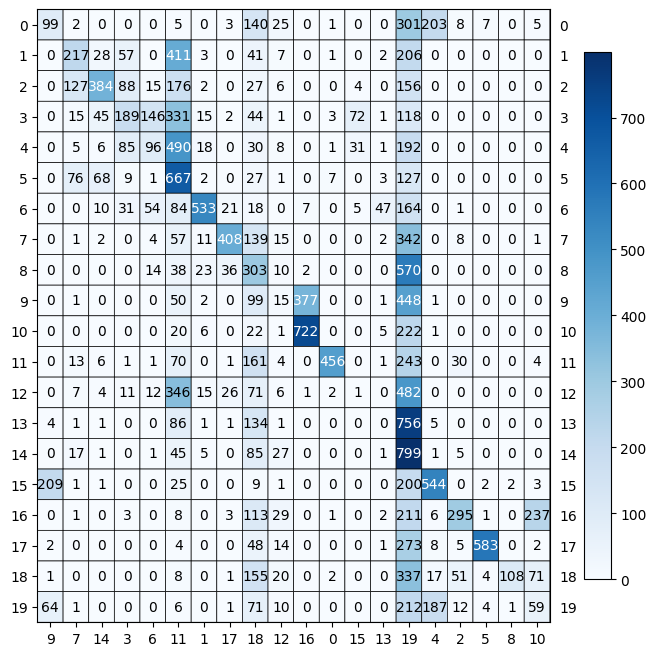

In [47]:
kmeans20_svd = KMeans(n_clusters=20, random_state=0)
svd_t = TruncatedSVD(n_components=best_svd_r, random_state=42)
data_svd = svd_t.fit_transform(data_tf_idf3)
kmeans20_svd.fit(data_svd)

cm = confusion_matrix(dataset.target, kmeans20_svd.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows)


In [42]:
evaluate(kmeans20_svd, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")

clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.331 ± 0.000
Completeness: 0.227 ± 0.000
V-measure: 0.270 ± 0.000
Adjusted Rand-Index: 0.098 ± 0.000
Adjusted_mutual_info_score: 0.269 ± 0.000


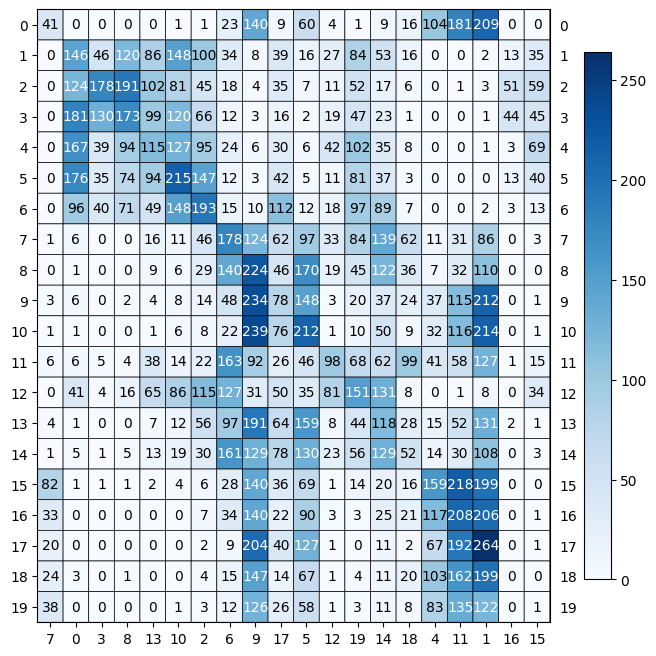

In [48]:
kmeans20_nmf = KMeans(n_clusters=20, random_state=0)
nmf_t = NMF(n_components=best_nmf_r, random_state=42)
data_nmf = nmf_t.fit_transform(data_tf_idf3)
kmeans20_nmf.fit(data_nmf)

cm = confusion_matrix(dataset.target, kmeans20_nmf.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows)

In [43]:
evaluate(kmeans20_nmf, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")

clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.194 ± 0.000
Completeness: 0.110 ± 0.000
V-measure: 0.141 ± 0.000
Adjusted Rand-Index: 0.054 ± 0.000
Adjusted_mutual_info_score: 0.140 ± 0.000


### Question11

In [39]:
import umap.plot as uplot
import umap.umap_ as umap

n_componets: 5
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.533 ± 0.000
Completeness: 0.297 ± 0.000
V-measure: 0.381 ± 0.000
Adjusted Rand-Index: 0.216 ± 0.000
Adjusted_mutual_info_score: 0.381 ± 0.000


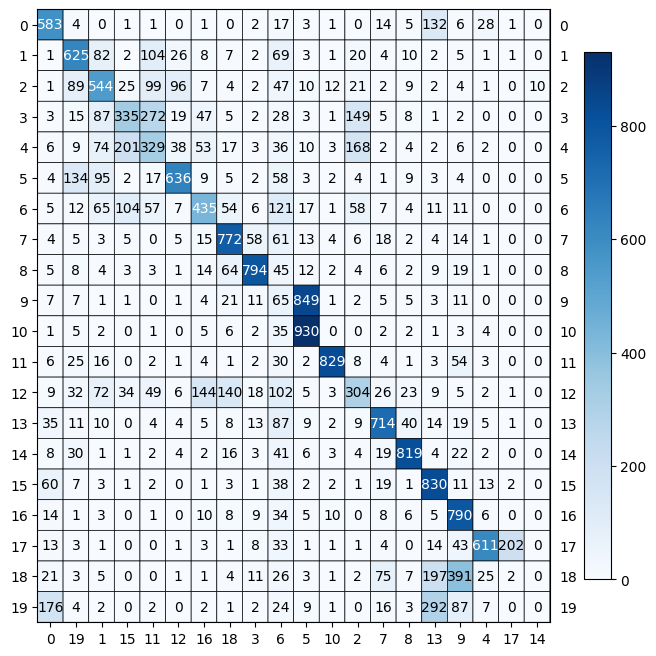

clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.009 ± 0.000
Completeness: 0.005 ± 0.000
V-measure: 0.007 ± 0.000
Adjusted Rand-Index: 0.002 ± 0.000
Adjusted_mutual_info_score: 0.006 ± 0.000


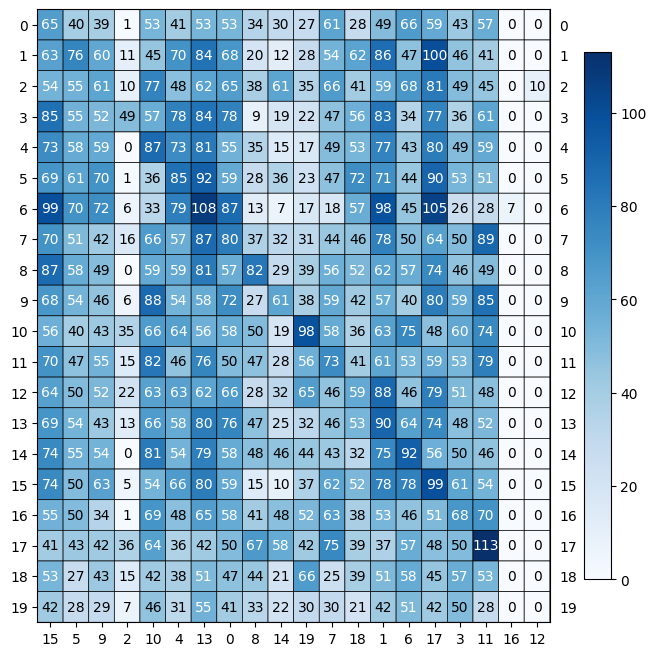

n_componets: 20
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.534 ± 0.000
Completeness: 0.304 ± 0.000
V-measure: 0.387 ± 0.000
Adjusted Rand-Index: 0.205 ± 0.000
Adjusted_mutual_info_score: 0.387 ± 0.000


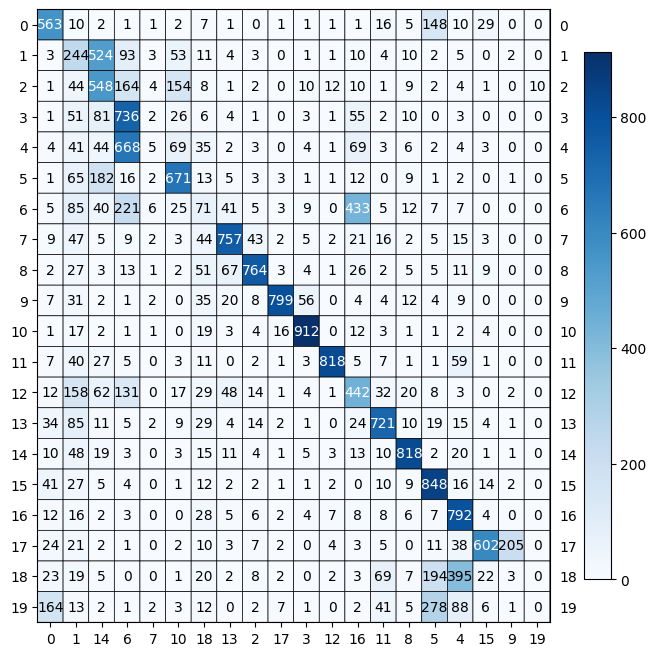

clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.008 ± 0.000
Completeness: 0.005 ± 0.000
V-measure: 0.006 ± 0.000
Adjusted Rand-Index: 0.002 ± 0.000
Adjusted_mutual_info_score: 0.005 ± 0.000


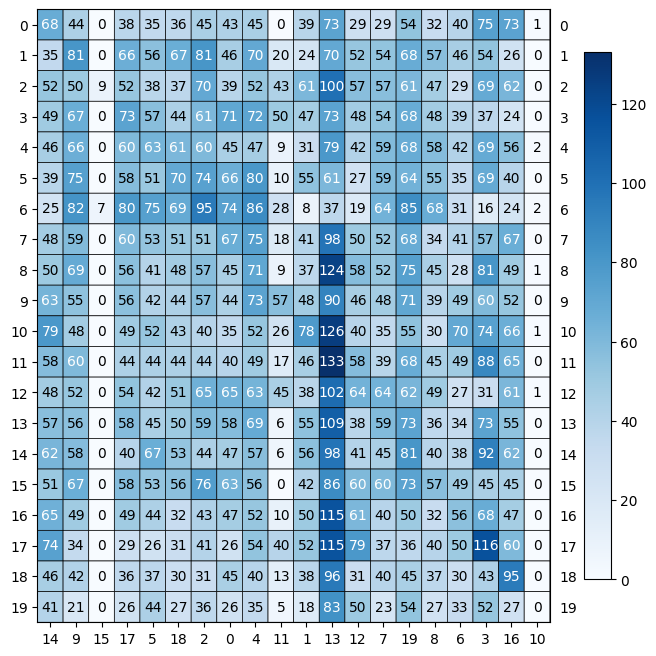

n_componets: 200
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.534 ± 0.000
Completeness: 0.292 ± 0.000
V-measure: 0.377 ± 0.000
Adjusted Rand-Index: 0.184 ± 0.000
Adjusted_mutual_info_score: 0.377 ± 0.000


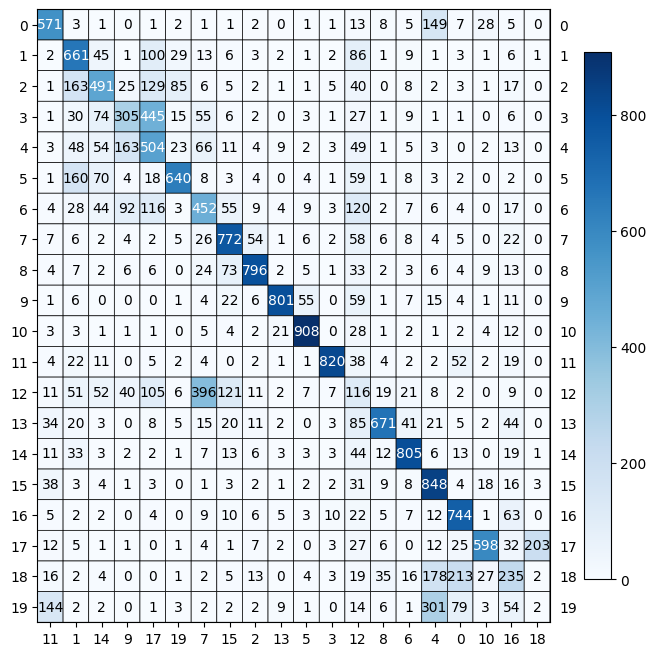

clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.009 ± 0.000
Completeness: 0.005 ± 0.000
V-measure: 0.006 ± 0.000
Adjusted Rand-Index: 0.002 ± 0.000
Adjusted_mutual_info_score: 0.005 ± 0.000


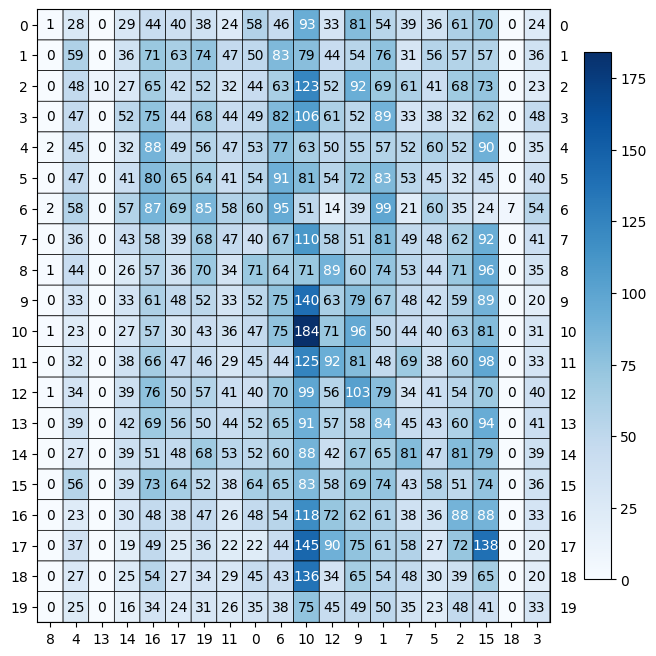

best r for cosine is 20, the average score is: 0.363
best r for euclidean is 5, the average score is: 0.006


In [44]:
n_comp = [5,20,200]
COS_results = defaultdict(list)
EUC_results = defaultdict(list)

best_cos = 0
best_euc = 0
best_cos_r = 0
best_euc_r = 0

for r in n_comp:
    print('n_componets: ' + str(r))

    umap_cos = umap.UMAP(n_components=r, metric='cosine')
    cos_data = umap_cos.fit_transform(data_tf_idf3)
    km = KMeans(n_clusters=20, random_state=0)
    km.fit(cos_data)

    COS_results["Homogeneity"].append(metrics.homogeneity_score(Y_binary, km.labels_))
    COS_results["Completeness"].append(metrics.completeness_score(Y_binary, km.labels_))
    COS_results["V-measure"].append(metrics.v_measure_score(Y_binary, km.labels_))
    COS_results["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(Y_binary, km.labels_))
    COS_results["Adjusted_mutual_info_score"].append(adjusted_mutual_info_score(Y_binary, km.labels_))

    avg_cos_score = (COS_results["Homogeneity"][-1] + COS_results["Completeness"][-1] \
    + COS_results["V-measure"][-1] + COS_results["Adjusted Rand-Index"][-1]  \
    + COS_results["Adjusted_mutual_info_score"][-1]) / 5.0

    evaluate(km, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")
    cm = confusion_matrix(dataset.target, km.labels_)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows)

    if(avg_cos_score > best_cos):
        best_cos = avg_cos_score
        best_cos_r = r
        best_cos_kmeans = km
        best_cos_data = cos_data

    umap_euc = umap.UMAP(n_components=r, metric='euclidean')
    euc_data = umap_euc.fit_transform(data_tf_idf3)
    km = KMeans(n_clusters=20, random_state=0)
    km.fit(euc_data)

    EUC_results["Homogeneity"].append(metrics.homogeneity_score(Y_binary, km.labels_))
    EUC_results["Completeness"].append(metrics.completeness_score(Y_binary, km.labels_))
    EUC_results["V-measure"].append(metrics.v_measure_score(Y_binary, km.labels_))
    EUC_results["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(Y_binary, km.labels_))
    EUC_results["Adjusted_mutual_info_score"].append(adjusted_mutual_info_score(Y_binary, km.labels_))

    avg_euc_score = (EUC_results["Homogeneity"][-1] + EUC_results["Completeness"][-1] \
    + EUC_results["V-measure"][-1] + EUC_results["Adjusted Rand-Index"][-1]  \
    + EUC_results["Adjusted_mutual_info_score"][-1]) / 5.0


    evaluate(km, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")
    cm = confusion_matrix(dataset.target, km.labels_)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows)

    
    if(avg_euc_score > best_euc):
        best_euc = avg_euc_score 
        best_euc_r = r
        best_euc_kmeans = km
        best_euc_data = euc_data


print(f"best r for cosine is {best_cos_r}, the average score is: {best_cos:.3f}")
print(f"best r for euclidean is {best_euc_r}, the average score is: {best_euc:.3f}")

### Question12 and Question 13 is stated on our report
### Question14

In [49]:
from sklearn.cluster import AgglomerativeClustering
agg_ward = AgglomerativeClustering(n_clusters= 20,linkage='ward')
agg_single = AgglomerativeClustering(n_clusters= 20,linkage='single')

# use the best n_componets for umap
print(f"umap use cosine n_componets = {best_cos_r} and ward agglomerativeClustering")
agg_ward_ = agg_ward.fit(best_cos_data)
evaluate(agg_ward_, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")

print(f"umap use euclidean n_componets = {best_euc_r} and ward agglomerativeClustering") 
agg_ward_ = agg_ward.fit(best_euc_data) 
evaluate(agg_ward_, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")

print(f"umap use cosine n_componets = {best_cos_r} and single agglomerativeClustering")
agg_single_ = agg_single.fit(best_cos_data)
evaluate(agg_single_, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")

print(f"umap use euclidean n_componets = {best_euc_r} and single agglomerativeClustering") 
agg_single_ = agg_single.fit(best_euc_data) 
evaluate(agg_single_, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")

umap use cosine n_componets = 20 and ward agglomerativeClustering
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.538 ± 0.000
Completeness: 0.299 ± 0.000
V-measure: 0.384 ± 0.000
Adjusted Rand-Index: 0.197 ± 0.000
Adjusted_mutual_info_score: 0.383 ± 0.000
umap use euclidean n_componets = 5 and ward agglomerativeClustering
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.010 ± 0.000
Completeness: 0.005 ± 0.000
V-measure: 0.007 ± 0.000
Adjusted Rand-Index: 0.002 ± 0.000
Adjusted_mutual_info_score: 0.006 ± 0.000
umap use cosine n_componets = 20 and single agglomerativeClustering
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.021 ± 0.000
Completeness: 0.182 ± 0.000
V-measure: 0.037 ± 0.000
Adjusted Rand-Index: 0.002 ± 0.000
Adjusted_mutual_info_score: 0.035 ± 0.000
umap use euclidean n_componets = 5 and single agglomerativeClustering
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.008 ± 0.000
Completeness: 0.165 ± 0.000
V-measure: 0.016 ± 0.000
Adjusted Rand-Index: -0.000 ± 0.000
Adjus

### Question15

In [51]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import hdbscan
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size= 100)
hdb_ = hdbscan_model.fit(best_cos_data)
evaluate(hdb_, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")

clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.419 ± 0.000
Completeness: 0.332 ± 0.000
V-measure: 0.370 ± 0.000
Adjusted Rand-Index: 0.210 ± 0.000
Adjusted_mutual_info_score: 0.370 ± 0.000


In [52]:
min_cluster = [20,100,200]
clu_results = defaultdict(list)

best_clu = 0
best_clu_r = 0

for r in min_cluster:
    print('min_clusters: ' + str(r))

    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size= r)
    hdb_label= hdbscan_model.fit_predict(best_cos_data)
    clu_results["Homogeneity"].append(metrics.homogeneity_score(Y_binary, hdb_label))
    clu_results["Completeness"].append(metrics.completeness_score(Y_binary, hdb_label))
    clu_results["V-measure"].append(metrics.v_measure_score(Y_binary, hdb_label))
    clu_results["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(Y_binary, hdb_label))
    clu_results["Adjusted_mutual_info_score"].append(adjusted_mutual_info_score(Y_binary, hdb_label))

    avg_clu_score = (clu_results["Homogeneity"][-1] + clu_results["Completeness"][-1] \
    + clu_results["V-measure"][-1] + clu_results["Adjusted Rand-Index"][-1]  \
    + clu_results["Adjusted_mutual_info_score"][-1]) / 5.0

    evaluate(hdbscan_model, data_tf_idf3, Y_binary, name="KMeans\non tf-idf vectors")
    
    if(avg_clu_score > best_clu):
        best_clu = avg_clu_score
        best_clu_r = r

print(f"best min_clusters is {best_clu_r}, the average score is: {best_clu:.3f}")


min_clusters: 20
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.000 ± 0.000
Completeness: 0.038 ± 0.000
V-measure: 0.001 ± 0.000
Adjusted Rand-Index: -0.000 ± 0.000
Adjusted_mutual_info_score: 0.000 ± 0.000
min_clusters: 100
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.419 ± 0.000
Completeness: 0.332 ± 0.000
V-measure: 0.370 ± 0.000
Adjusted Rand-Index: 0.210 ± 0.000
Adjusted_mutual_info_score: 0.370 ± 0.000
min_clusters: 200
clustering done in 0.00 ± 0.00 s 
Homogeneity: 0.413 ± 0.000
Completeness: 0.327 ± 0.000
V-measure: 0.365 ± 0.000
Adjusted Rand-Index: 0.210 ± 0.000
Adjusted_mutual_info_score: 0.364 ± 0.000
best min_clusters is 100, the average score is: 0.340


### Question16

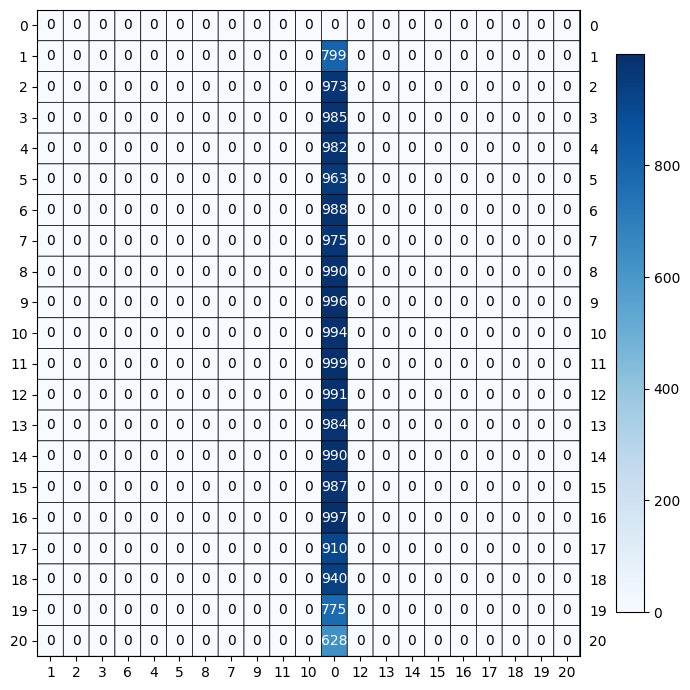

In [8]:
hdbscan_best = hdbscan.HDBSCAN(min_cluster_size= best_clu_r)
hdb_data = hdbscan_best.fit(data_tf_idf3)
cm = confusion_matrix(dataset.target, hdbscan_best.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows)

### Question17

In [ ]:
import pickle
## dumping umap
for r in [5, 20, 200]:
  file = open(f'umap_{r}.obj', 'wb')
  umap_ = umap.UMAP(n_components=r, metric='cosine')
  X_svd = umap_.fit_transform(data_tf_idf3)
  X_svd = np.nan_to_num(X_svd)
  pickle.dump(X_svd, file)
  file.close()

In [ ]:
import pickle
## dumping svd
for r in [5, 20, 200]:
  file = open(f'svd_{r}.obj', 'wb')
  svd_ = TruncatedSVD(n_components=r)
  X_svd = svd_.fit_transform(data_tf_idf3)
  X_svd = np.nan_to_num(X_svd)
  pickle.dump(X_svd, file)
  file.close()

In [ ]:
import pickle
## dumping nmf
for r in [5, 20, 200]:
  file = open(f'nmf_{r}.obj', 'wb')
  nmf_ = NMF(n_components=r)
  X_svd = nmf_.fit_transform(data_tf_idf3)
  X_svd = np.nan_to_num(X_svd)
  pickle.dump(X_svd, file)
  file.close()

In [ ]:
#1 Using k-means without dimensinality reduction [k=10,20,50]
best_k = 0
best_result = 0
for k in [10,20,50]:
  km_ = KMeans(n_clusters=k,random_state=0,max_iter=1000,n_init=30)
  y_pred = km_.fit_predict(data_tf_idf3)
  result = metrics.adjusted_rand_score(Y_binary,y_pred)
  if result > best_result:
    best_k = k
    best_result = result
  print(f"Without Dimensionality Reduction, Clustering Method: K-means, k = {k} ", result)

print(f"Without Dimensionality Reduction, Clustering Method: K-means, best_k = {best_k} , best_result = {best_result}")

Without Dimensionality Reduction, Clustering Method: K-means, k = 10  0.12298480871944135
Without Dimensionality Reduction, Clustering Method: K-means, k = 20  0.07657149110147805
Without Dimensionality Reduction, Clustering Method: K-means, k = 50  0.058323393065727556
Without Dimensionality Reduction, Clustering Method: K-means, best_k = 10 , best_result = 0.12298480871944135


In [ ]:
#2 Using k-means with SVD reduction [k=10,20,50] [r=5,20,200]
best_r = 0
best_k = 0
best_result = 0
for r in [5,20,200]:
  file = open(f'svd_{r}.obj', 'rb')
  X_svd = pickle.load(file)
  file.close()
  # svd_ = TruncatedSVD(n_components=r)
  # X_svd = svd_.fit_transform(data_tf_idf3)
  for k in [10,20,50]:
    km_ = KMeans(n_clusters=k,random_state=0,max_iter=1000,n_init=30)
    y_pred = km_.fit_predict(X_svd)
    result = metrics.adjusted_rand_score(Y_binary,y_pred)
    if result > best_result:
      best_r = r
      best_k = k
      best_result = result
    print(f"With SVD Dimensionality Reduction r = {r}, Clustering Method: K-means, k = {k} ", result)

print(f"With SVD Dimensionality Reduction best_r = {best_r}, Clustering Method: K-means, best_k = {best_k} , best_result = {best_result}")

With SVD Dimensionality Reduction r = 5, Clustering Method: K-means, k = 10  0.11499615604359621
With SVD Dimensionality Reduction r = 5, Clustering Method: K-means, k = 20  0.09041421513942735
With SVD Dimensionality Reduction r = 5, Clustering Method: K-means, k = 50  0.04814386789830855
With SVD Dimensionality Reduction r = 20, Clustering Method: K-means, k = 10  0.10296792705153543
With SVD Dimensionality Reduction r = 20, Clustering Method: K-means, k = 20  0.07229439755949905
With SVD Dimensionality Reduction r = 20, Clustering Method: K-means, k = 50  0.056455722750361634
With SVD Dimensionality Reduction r = 200, Clustering Method: K-means, k = 10  0.12423240533402541
With SVD Dimensionality Reduction r = 200, Clustering Method: K-means, k = 20  0.08519880201681075
With SVD Dimensionality Reduction r = 200, Clustering Method: K-means, k = 50  0.055871807089970034
With SVD Dimensionality Reduction best_r = 200, Clustering Method: K-means, best_k = 10 , best_result = 0.1242324053

In [ ]:
#3 Using k-means with NMF reduction [k=10,20,50] [r=5,20,200]

best_r = 0
best_k = 0
best_result = 0
for r in [5,20,200]:
  file = open(f'nmf_{r}.obj', 'rb')
  X_svd = pickle.load(file)
  file.close()
  # nmf_ = NMF(n_components=r)
  # X_nmf = nmf_.fit_transform(data_tf_idf3)
  for k in [10,20,50]:
    km_ = KMeans(n_clusters=k,random_state=0,max_iter=1000,n_init=30)
    y_pred = km_.fit_predict(X_svd)
    result = metrics.adjusted_rand_score(Y_binary,y_pred)
    if result > best_result:
      best_r = r
      best_k = k
      best_result = result
    print(f"With NMF Dimensionality Reduction r = {r}, Clustering Method: K-means, k = {k} ", result)

print(f"With NMF Dimensionality Reduction best_r = {best_r}, Clustering Method: K-means, best_k = {best_k} , best_result = {best_result}")

With NMF Dimensionality Reduction r = 5, Clustering Method: K-means, k = 10  0.07669021327115816
With NMF Dimensionality Reduction r = 5, Clustering Method: K-means, k = 20  0.06671480098168675
With NMF Dimensionality Reduction r = 5, Clustering Method: K-means, k = 50  0.04249791864312421
With NMF Dimensionality Reduction r = 20, Clustering Method: K-means, k = 10  0.06342211981938245
With NMF Dimensionality Reduction r = 20, Clustering Method: K-means, k = 20  0.0655807890543427
With NMF Dimensionality Reduction r = 20, Clustering Method: K-means, k = 50  0.051701912816332816
With NMF Dimensionality Reduction r = 200, Clustering Method: K-means, k = 10  0.002788139578746605
With NMF Dimensionality Reduction r = 200, Clustering Method: K-means, k = 20  0.01514401931605396
With NMF Dimensionality Reduction r = 200, Clustering Method: K-means, k = 50  0.01954903417500828
With NMF Dimensionality Reduction best_r = 5, Clustering Method: K-means, best_k = 10 , best_result = 0.0766902132711

In [ ]:
#4 Using k-means with UMAP reduction [k=10,20,50] [r=5,20,200]

best_r = 0
best_k = 0
best_result = 0
for r in [5,20,200]:
  file = open(f'umap_{r}.obj', 'rb')
  X_svd = pickle.load(file)
  file.close()
  # umap_ = umap.UMAP(n_components=r, metric='cosine')
  # X_svd = umap_.fit_transform(data_tf_idf3)
  for k in [10,20,50]:
    km_ = KMeans(n_clusters=k,random_state=0,max_iter=1000,n_init=30)
    y_pred = km_.fit_predict(X_svd)
    result = metrics.adjusted_rand_score(Y_binary,y_pred)
    if result > best_result:
      best_r = r
      best_k = k
      best_result = result
    print(f"With UMAP Dimensionality Reduction r = {r}, Clustering Method: K-means, k = {k} ", result)

print(f"With UMAP Dimensionality Reduction best_r = {best_r}, Clustering Method: K-means, best_k = {best_k} , best_result = {best_result}")

With UMAP Dimensionality Reduction r = 5, Clustering Method: K-means, k = 10  0.22183715096452636
With UMAP Dimensionality Reduction r = 5, Clustering Method: K-means, k = 20  0.20691564611526206
With UMAP Dimensionality Reduction r = 5, Clustering Method: K-means, k = 50  0.12171406066731445
With UMAP Dimensionality Reduction r = 20, Clustering Method: K-means, k = 10  0.227122474521217
With UMAP Dimensionality Reduction r = 20, Clustering Method: K-means, k = 20  0.22393739514220942
With UMAP Dimensionality Reduction r = 20, Clustering Method: K-means, k = 50  0.1405408861078544
With UMAP Dimensionality Reduction r = 200, Clustering Method: K-means, k = 10  0.24158088102041522
With UMAP Dimensionality Reduction r = 200, Clustering Method: K-means, k = 20  0.24255663256252014
With UMAP Dimensionality Reduction r = 200, Clustering Method: K-means, k = 50  0.13055004081977653
With UMAP Dimensionality Reduction best_r = 200, Clustering Method: K-means, best_k = 20 , best_result = 0.24255

In [ ]:
#5 Using AgglomerativeClustering without dimensinality reduction [k=20]
# causing too much time, not run
from sklearn.cluster import AgglomerativeClustering
agg_ward = AgglomerativeClustering(n_clusters=20,linkage='ward')
y_pred = agg_ward.fit_predict(data_tf_idf3.toarray())
result = metrics.adjusted_rand_score(Y_binary,y_pred)
print(f"Without Dimensionality Reduction, Clustering Method: K-means, k = 20 ", result)

In [ ]:
#6 Using AgglomerativeClustering with SVD reduction [r=5,20,200]
from sklearn.cluster import AgglomerativeClustering
best_r = 0
best_result = 0
for r in [5,20,200]:
  file = open(f'svd_{r}.obj', 'rb')
  X_svd = pickle.load(file)
  file.close()
  # svd_ = TruncatedSVD(n_components=r)
  # X_svd = svd_.fit_transform(data_tf_idf3)
  agg_ward = AgglomerativeClustering(n_clusters=20,linkage='ward')
  y_pred = agg_ward.fit_predict(X_svd)
  result = metrics.adjusted_rand_score(Y_binary,y_pred)
  if result > best_result:
    best_r = r
    best_result = result
  print(f"With SVD Dimensionality Reduction r = {r}, Clustering Method: AgglomerativeClustering, r = {r} ", result)

print(f"With SVD Dimensionality Reduction best_r = {best_r}, Clustering Method: AgglomerativeClustering, best_result = {best_result}")

With SVD Dimensionality Reduction r = 5, Clustering Method: AgglomerativeClustering, r = 5  0.09203719648907432
With SVD Dimensionality Reduction r = 20, Clustering Method: AgglomerativeClustering, r = 20  0.09274187811699038
With SVD Dimensionality Reduction r = 200, Clustering Method: AgglomerativeClustering, r = 200  0.09341058654516633
With SVD Dimensionality Reduction best_r = 200, Clustering Method: AgglomerativeClustering, best_result = 0.09341058654516633


In [ ]:
#7 Using AgglomerativeClustering with NMF reduction [r=5,20,200]
from sklearn.cluster import AgglomerativeClustering
best_r = 0
best_result = 0
for r in [5,20,200]:
  file = open(f'nmf_{r}.obj', 'rb')
  X_nmf = pickle.load(file)
  file.close()
  # nmf_ = NMF(n_components=r)
  # X_nmf = nmf_.fit_transform(data_tf_idf3)
  agg_ward = AgglomerativeClustering(n_clusters=20,linkage='ward')
  y_pred = agg_ward.fit_predict(X_nmf)
  result = metrics.adjusted_rand_score(Y_binary,y_pred)
  if result > best_result:
    best_r = r
    best_result = result
  print(f"With NMF Dimensionality Reduction r = {r}, Clustering Method: AgglomerativeClustering, r = {r} ", result)

print(f"With NMF Dimensionality Reduction best_r = {best_r}, Clustering Method: AgglomerativeClustering, best_result = {best_result}")

With NMF Dimensionality Reduction r = 5, Clustering Method: AgglomerativeClustering, r = 5  0.07315663293267735
With NMF Dimensionality Reduction r = 20, Clustering Method: AgglomerativeClustering, r = 20  0.09652612630921366
With NMF Dimensionality Reduction r = 200, Clustering Method: AgglomerativeClustering, r = 200  0.008523940255761885
With NMF Dimensionality Reduction best_r = 20, Clustering Method: AgglomerativeClustering, best_result = 0.09652612630921366


In [ ]:
#8 Using AgglomerativeClustering with UMAP reduction [r=5,20,200]
from sklearn.cluster import AgglomerativeClustering
best_r = 0
best_result = 0
for r in [5,20,200]:
  file = open(f'umap_{r}.obj', 'rb')
  X_svd = pickle.load(file)
  file.close()
  # umap_ = umap.UMAP(n_components=r, metric='cosine')
  # X_svd = umap_.fit_transform(data_tf_idf3)
  agg_ward = AgglomerativeClustering(n_clusters=20,linkage='ward')
  y_pred = agg_ward.fit_predict(X_svd)
  result = metrics.adjusted_rand_score(Y_binary,y_pred)
  if result > best_result:
    best_r = r
    best_result = result
  print(f"With UMAP Dimensionality Reduction r = {r}, Clustering Method: AgglomerativeClustering, r = {r} ", result)
print(f"With UMAP Dimensionality Reduction best_r = {best_r}, Clustering Method: AgglomerativeClustering, best_result = {best_result}")

With UMAP Dimensionality Reduction r = 5, Clustering Method: AgglomerativeClustering, r = 5  0.21456619768075202
With UMAP Dimensionality Reduction r = 20, Clustering Method: AgglomerativeClustering, r = 20  0.22808879369491192
With UMAP Dimensionality Reduction r = 200, Clustering Method: AgglomerativeClustering, r = 200  0.2242264674981165
With UMAP Dimensionality Reduction best_r = 20, Clustering Method: AgglomerativeClustering, best_result = 0.22808879369491192


In [7]:
import hdbscan
min_cluster_size_list = [100,200]

def hdbscan_compare(X_umap,label,min_cluster_size_list):
  for mcs in min_cluster_size_list:
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=mcs)
    y_pred_hdbscan = hdbscan_model.fit_predict(X_umap)

    homo = metrics.homogeneity_score(label,y_pred_hdbscan)
    comp = metrics.completeness_score(label,y_pred_hdbscan)
    v = metrics.v_measure_score(label,y_pred_hdbscan)
    adj = metrics.adjusted_rand_score(label,y_pred_hdbscan)
    sic = adjusted_mutual_info_score(label,y_pred_hdbscan)

    mean_ = (homo + comp + v + adj + sic) / 5.0

    print(f"HDBSCAN min_cluster_size={mcs},homogeneity_score={homo:.3f},Completeness={comp:.3f},V-measure={v:.3f},Adjusted Rand-Index={adj:.3f}, Adjusted_mutual_info_score={sic:.3f}, mean={mean_:.3f}")
    return mean_

In [5]:
#9 Using HDBSCAN without dimensinality reduction [min_cluster=100,200]
hdbscan_compare(data_tf_idf3,Y_binary,min_cluster_size_list)

HDBSCAN min_cluster_size=100,homogeneity_score=0.000,Completeness=1.000,V-measure=0.000,Adjusted Rand-Index=0.000, Adjusted_mutual_info_score=-0.000, mean=0.200 
 0.19999999999999984
HDBSCAN min_cluster_size=200,homogeneity_score=0.000,Completeness=1.000,V-measure=0.000,Adjusted Rand-Index=0.000, Adjusted_mutual_info_score=-0.000, mean=0.200 
 0.19999999999999984


In [2]:
#10 Using HDBSCAN with SVD reduction [min_cluster=100,200] [r=5,20,200]
# not run cause Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
best_r = 0
best_result = 0
for r in [5,20,200]:
  file = open(f'svd_{r}.obj', 'rb')
  X_svd = pickle.load(file)
  file.close()
  # svd_ = TruncatedSVD(n_components=r)
  # X_svd = svd_.fit_transform(data_tf_idf3)
  result = hdbscan_compare(X_svd,Y_binary,min_cluster_size_list)
  if result > best_result:
    best_r = r
    best_result = result
  print(f"With SVD Dimensionality Reduction r = {r}, Clustering Method: HDBSCAN, r = {r} ", result)
print(f"With SVD Dimensionality Reduction best_r = {best_r}, Clustering Method: HDBSCAN, best_result = {best_result}")

HDBSCAN min_cluster_size=100,homogeneity_score=0.000,Completeness=1.000,V-measure=0.000,Adjusted Rand-Index=0.000, Adjusted_mutual_info_score=-0.000, mean=0.200 
 With SVD Dimensionality Reduction r = 5, Clustering Method: HDBSCAN, r = 5  0.19999999999999984 
 HDBSCAN min_cluster_size=100,homogeneity_score=0.000,Completeness=1.000,V-measure=0.000,Adjusted Rand-Index=0.000, Adjusted_mutual_info_score=-0.000, mean=0.200 
 With SVD Dimensionality Reduction r = 20, Clustering Method: HDBSCAN, r = 20  0.19999999999999984 
 HDBSCAN min_cluster_size=100,homogeneity_score=0.000,Completeness=1.000,V-measure=0.000,Adjusted Rand-Index=0.000, Adjusted_mutual_info_score=-0.000, mean=0.200 
 With SVD Dimensionality Reduction r = 200, Clustering Method: HDBSCAN, r = 200  0.19999999999999984 
 With SVD Dimensionality Reduction best_r = 5, Clustering Method: HDBSCAN, best_result = 0.19999999999999984


In [4]:
#11 Using HDBSCAN with NMF reduction [min_cluster=100,200] [r=5,20,200]
best_r = 0
best_result = 0
for r in [5,20,200]:
  file = open(f'nmf_{r}.obj', 'rb')
  X_svd = pickle.load(file)
  file.close()
  # nmf_ = NMF(n_components=r)
  # X_nmf = nmf_.fit_transform(data_tf_idf3)
  result = hdbscan_compare(X_svd,Y_binary,min_cluster_size_list)
  if result > best_result:
    best_r = r
    best_result = result
  print(f"With NMF Dimensionality Reduction r = {r}, Clustering Method: HDBSCAN, r = {r} ", result)
print(f"With NMF Dimensionality Reduction best_r = {best_r}, Clustering Method: HDBSCAN, best_result = {best_result}")

HDBSCAN min_cluster_size=100,homogeneity_score=0.049,Completeness=0.122,V-measure=0.070,Adjusted Rand-Index=0.040, Adjusted_mutual_info_score=0.070, mean=0.070 
 With NMF Dimensionality Reduction r = 5, Clustering Method: HDBSCAN, r = 5  0.07005456318209 
 HDBSCAN min_cluster_size=100,homogeneity_score=0.000,Completeness=1.000,V-measure=0.000,Adjusted Rand-Index=0.000, Adjusted_mutual_info_score=-0.000, mean=0.200 
 With NMF Dimensionality Reduction r = 20, Clustering Method: HDBSCAN, r = 20  0.19999999999999984 
 HDBSCAN min_cluster_size=100,homogeneity_score=0.000,Completeness=1.000,V-measure=0.000,Adjusted Rand-Index=0.000, Adjusted_mutual_info_score=-0.000, mean=0.200 
 With NMF Dimensionality Reduction r = 200, Clustering Method: HDBSCAN, r = 200  0.19999999999999984 
 With NMF Dimensionality Reduction best_r = 20, Clustering Method: HDBSCAN, best_result = 0.19999999999999984


In [3]:
#12 Using HDBSCAN with UMAP reduction [min_cluster=100,200] [r=5,20,200]
best_r = 0
best_result = 0
for r in [5,20,200]:
  file = open(f'umap_{r}.obj', 'rb')
  X_svd = pickle.load(file)
  file.close()
  # umap_ = umap.UMAP(n_components=r, metric='cosine')
  # X_svd = umap_.fit_transform(data_tf_idf3)
  result = hdbscan_compare(X_svd,Y_binary,min_cluster_size_list)
  if result > best_result:
    best_r = r
    best_result = result
  print(f"With UMAP Dimensionality Reduction r = {r}, Clustering Method: HDBSCAN, r = {r} ", result)
print(f"With UMAP Dimensionality Reduction best_r = {best_r}, Clustering Method: HDBSCAN, best_result = {best_result}")

HDBSCAN min_cluster_size=100,homogeneity_score=0.430,Completeness=0.335,V-measure=0.376,Adjusted Rand-Index=0.229, Adjusted_mutual_info_score=0.376, mean=0.349 
 With UMAP Dimensionality Reduction r = 5, Clustering Method: HDBSCAN, r = 5  0.3492473058590584 
 HDBSCAN min_cluster_size=100,homogeneity_score=0.414,Completeness=0.334,V-measure=0.370,Adjusted Rand-Index=0.231, Adjusted_mutual_info_score=0.369, mean=0.344 
 With UMAP Dimensionality Reduction r = 20, Clustering Method: HDBSCAN, r = 20  0.34351583450504447 
 HDBSCAN min_cluster_size=100,homogeneity_score=0.411,Completeness=0.322,V-measure=0.361,Adjusted Rand-Index=0.195, Adjusted_mutual_info_score=0.361, mean=0.330 
 With UMAP Dimensionality Reduction r = 200, Clustering Method: HDBSCAN, r = 200  0.3299164275939991 
 With UMAP Dimensionality Reduction best_r = 5, Clustering Method: HDBSCAN, best_result = 0.3492473058590584


### Question19
### Question20,21,22 are stated on Our Report

In [6]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 58/58 [00:42<00:00,  1.35it/s]


In [7]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


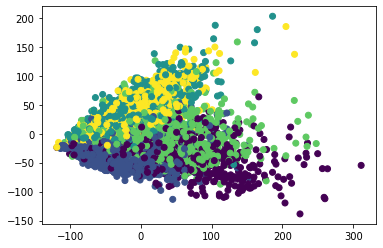

In [8]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

### Question23

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


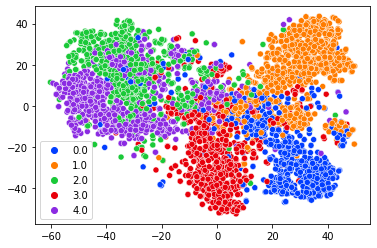

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
f_tSNE = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(f_all)
palette = sns.color_palette("bright", 5)
sns.scatterplot(f_tSNE[:,0], f_tSNE[:,1], hue=y_all, legend='full', palette=palette)

### Question24

In [10]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [8]:
#Using k-means without dimensinality reduction
km_5 = KMeans(n_clusters=5,random_state=0,max_iter=1000,n_init=30)
y_pred = km_5.fit_predict(f_all)
result = metrics.adjusted_rand_score(y_all,y_pred)
print("Without Dimensionality Reduction, Clustering Method: K-means", result)

Without Dimensionality Reduction, Clustering Method: K-means 0.19178888830300925


In [9]:
#Using k-means with SVD dimension reduction
km_5 = KMeans(n_clusters=5,random_state=0,max_iter=1000,n_init=30)
svd_ = TruncatedSVD(n_components=50)
X_svd = svd_.fit_transform(f_all)
y_pred = km_5.fit_predict(X_svd)

result = metrics.adjusted_rand_score(y_all,y_pred)
print("With SVD Dimensionality Reduction, Clustering Method: K-means", result)

With SVD Dimensionality Reduction, Clustering Method: K-means 0.19203019903753804


In [10]:
#Using k-means with umap dimension reduction
km_5 = KMeans(n_clusters=5,random_state=0,max_iter=1000,n_init=30)
umap_ = umap.UMAP(n_components=50, metric='cosine')
X_umap = umap_.fit_transform(f_all)
y_pred = km_5.fit_predict(X_umap)

result = metrics.adjusted_rand_score(y_all,y_pred)
print("With UMAP Dimensionality Reduction, Clustering Method: K-means", result)

With UMAP Dimensionality Reduction, Clustering Method: K-means 0.4668755531759629


In [11]:
#Using k-means with Autoencoder dimension reduction
km_5 = KMeans(n_clusters=5,random_state=0,max_iter=1000,n_init=30)
auto_ = Autoencoder(50)
X_auto = auto_.fit_transform(f_all)
y_pred = km_5.fit_predict(X_auto)

result = metrics.adjusted_rand_score(y_all,y_pred)
print("With Autoencoder Dimensionality Reduction, Clustering Method: K-means", result)

100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


With Autoencoder Dimensionality Reduction, Clustering Method: K-means 0.23600012109898233


In [12]:
from sklearn.cluster import AgglomerativeClustering
#Using AgglomerativeClustering without dimensinality reduction
agg_ward = AgglomerativeClustering(n_clusters=5,linkage='ward')
y_pred = agg_ward.fit_predict(f_all)
result = metrics.adjusted_rand_score(y_all,y_pred)
print("Without Dimensionality Reduction, Clustering Method: AgglomerativeClustering", result)


Without Dimensionality Reduction, Clustering Method: AgglomerativeClustering 0.18855278251971858


In [24]:
from sklearn.cluster import AgglomerativeClustering
#Using AgglomerativeClustering with SVD dimension reduction
agg_ward = AgglomerativeClustering(n_clusters=5,linkage='ward')
svd_ = TruncatedSVD(n_components=50)
X_svd = svd_.fit_transform(f_all)
y_pred = agg_ward.fit_predict(X_svd)
result = metrics.adjusted_rand_score(y_all,y_pred)
print("with SVD dimension reduction, Clustering Method: AgglomerativeClustering", result)

with SVD dimension reduction, Clustering Method: AgglomerativeClustering 0.26928906552094006


In [23]:
from sklearn.cluster import AgglomerativeClustering
#Using AgglomerativeClustering with umap dimension reduction
agg_ward = AgglomerativeClustering(n_clusters=5,linkage='ward')
umap_ = umap.UMAP(n_components=50, metric='cosine')
X_umap = umap_.fit_transform(f_all)
y_pred = agg_ward.fit_predict(X_umap)
result = metrics.adjusted_rand_score(y_all,y_pred)
print("with UMAP dimension reduction, Clustering Method: AgglomerativeClustering", result)

with UMAP dimension reduction, Clustering Method: AgglomerativeClustering 0.46863482358684355


In [22]:
from sklearn.cluster import AgglomerativeClustering
#Using AgglomerativeClustering with Autoencoder dimension reduction
agg_ward = AgglomerativeClustering(n_clusters=5,linkage='ward')
auto_ = Autoencoder(50)
X_auto = auto_.fit_transform(f_all)
y_pred = agg_ward.fit_predict(X_auto)
result = metrics.adjusted_rand_score(y_all,y_pred)
print("with Autoencoder dimension reduction, Clustering Method: AgglomerativeClustering", result)

100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


with Autoencoder dimension reduction, Clustering Method: AgglomerativeClustering 0.2935308417813973


In [ ]:
import hdbscan
min_cluster_size_list = [10,50,100]
min_samples_list = [1,2,3]

def hdbscan_compare(X_umap,label,min_cluster_size_list,min_samples_list):
  for mcs in min_cluster_size_list:
    for ms in min_samples_list:
      hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=mcs,min_samples=ms)
      y_pred_hdbscan = hdbscan_model.fit_predict(X_umap)

      homo = metrics.homogeneity_score(label,y_pred_hdbscan)
      comp = metrics.completeness_score(label,y_pred_hdbscan)
      v = metrics.v_measure_score(label,y_pred_hdbscan)
      adj = metrics.adjusted_rand_score(label,y_pred_hdbscan)
      sic = adjusted_mutual_info_score(label,y_pred_hdbscan)
      mean_ = (homo + comp + v + adj + sic) / 5.0

      print(f"HDBSCAN min_cluster_size={mcs},min_samples={ms},homogeneity_score={homo:.3f},Completeness={comp:.3f},V-measure={v:.3f},Adjusted Rand-Index={adj:.3f}, Adjusted_mutual_info_score={sic:.3f}, mean={mean_:.3f}")

In [ ]:
print("with no dimension reduction, Clustering Method: HDBSCAN")
hdbscan_compare(f_all,y_all,min_cluster_size_list,min_samples_list)

with no dimension reduction, Clustering Method: HDBSCAN 
 HDBSCAN min_cluster_size=10,min_samples=1,homogeneity_score=0.014,Completeness=0.042,V-measure=0.021,Adjusted Rand-Index=0.015, Silhouette Coefficient=0.174, mean=0.053 
 HDBSCAN min_cluster_size=10,min_samples=2,homogeneity_score=0.014,Completeness=0.042,V-measure=0.021,Adjusted Rand-Index=0.015, Silhouette Coefficient=0.174, mean=0.053 
 HDBSCAN min_cluster_size=10,min_samples=3,homogeneity_score=0.021,Completeness=0.058,V-measure=0.030,Adjusted Rand-Index=0.008, Silhouette Coefficient=-0.076, mean=0.008


In [ ]:
print("with SVD dimension reduction, Clustering Method: HDBSCAN")
svd_ = TruncatedSVD(n_components=50)
X_svd = svd_.fit_transform(f_all)
hdbscan_compare(X_svd,y_all,min_cluster_size_list,min_samples_list)

with SVD dimension reduction, Clustering Method: HDBSCAN 
 HDBSCAN min_cluster_size=10,min_samples=1,homogeneity_score=0.033,Completeness=0.080,V-measure=0.047,Adjusted Rand-Index=0.017, Silhouette Coefficient=-0.123, mean=0.011 
 HDBSCAN min_cluster_size=10,min_samples=2,homogeneity_score=0.027,Completeness=0.071,V-measure=0.039,Adjusted Rand-Index=0.010, Silhouette Coefficient=-0.106, mean=0.008 
 HDBSCAN min_cluster_size=10,min_samples=3,homogeneity_score=0.026,Completeness=0.064,V-measure=0.037,Adjusted Rand-Index=0.016, Silhouette Coefficient=-0.061, mean=0.016


In [ ]:
print("with AutoEncoder dimension reduction, Clustering Method: HDBSCAN")
auto_ = Autoencoder(50)
X_auto = auto_.fit_transform(f_all)
hdbscan_compare(X_auto,y_all,min_cluster_size_list,min_samples_list)

with AutoEncoder dimension reduction, Clustering Method: HDBSCAN 
 HDBSCAN min_cluster_size=10,min_samples=1,homogeneity_score=0.022,Completeness=0.053,V-measure=0.032,Adjusted Rand-Index=0.030, Silhouette Coefficient=0.043, mean=0.036 
 HDBSCAN min_cluster_size=10,min_samples=2,homogeneity_score=0.029,Completeness=0.075,V-measure=0.042,Adjusted Rand-Index=0.015, Silhouette Coefficient=-0.123, mean=0.008 
 HDBSCAN min_cluster_size=10,min_samples=3,homogeneity_score=0.025,Completeness=0.071,V-measure=0.037,Adjusted Rand-Index=0.010, Silhouette Coefficient=-0.134, mean=0.002


In [ ]:
print("with UMAP dimension reduction, Clustering Method: HDBSCAN")
umap_ = umap.UMAP(n_components=50, metric='cosine')
X_umap = umap_.fit_transform(f_all)
hdbscan_compare(X_umap,y_all,min_cluster_size_list,min_samples_list)

HDBSCAN min_cluster_size=10,min_samples=1,homogeneity_score=0.179,Completeness=0.635,V-measure=0.280,Adjusted Rand-Index=0.095, Silhouette Coefficient=0.549, mean=0.348
HDBSCAN min_cluster_size=10,min_samples=2,homogeneity_score=0.179,Completeness=0.635,V-measure=0.280,Adjusted Rand-Index=0.095, Silhouette Coefficient=0.549, mean=0.348
HDBSCAN min_cluster_size=10,min_samples=3,homogeneity_score=0.179,Completeness=0.635,V-measure=0.280,Adjusted Rand-Index=0.095, Silhouette Coefficient=0.549, mean=0.348
HDBSCAN min_cluster_size=50,min_samples=1,homogeneity_score=0.179,Completeness=0.635,V-measure=0.280,Adjusted Rand-Index=0.095, Silhouette Coefficient=0.549, mean=0.348
HDBSCAN min_cluster_size=50,min_samples=2,homogeneity_score=0.179,Completeness=0.635,V-measure=0.280,Adjusted Rand-Index=0.095, Silhouette Coefficient=0.549, mean=0.348
HDBSCAN min_cluster_size=50,min_samples=3,homogeneity_score=0.179,Completeness=0.635,V-measure=0.280,Adjusted Rand-Index=0.095, Silhouette Coefficient=0.54

### Question25

In [34]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                X_ = X_.cuda()
                output = self(X_)
                loss = criterion(output,y_.cuda())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self
    
    def eval(self, X_test, y_test):
        X_pred = self(torch.tensor(X_test,dtype=torch.float32, device='cuda'))
        logit = X_pred.argmax(dim=1)
        acc = torch.sum(logit == torch.tensor(y_test,dtype=torch.float32, device='cuda'))/X_test.shape[0]
        with torch.no_grad():
          acc = acc.cpu().numpy()
        return acc

In [28]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

In [ ]:
model = MLP(4096)
model.train(X_train, y_train)
acc = model.eval(X_test, y_test)

In [36]:
print(f"the VGG feature accuracy={acc}")

the VGG feature accuracy=0.9305176734924316


In [41]:
# Using SVD 
svd_ = TruncatedSVD(n_components=50)
X_train_ = svd_.fit_transform(X_train)
X_test_ = svd_.fit_transform(X_test)
model = MLP(50)
model.train(X_train_, y_train)
acc = model.eval(X_test_, y_test)
print(f"the SVD and MLP feature accuracy={acc}")

100%|██████████| 100/100 [00:06<00:00, 15.85it/s]

the SVD and MLP feature accuracy=0.30381470918655396


In [43]:
# Using UMAP
umap_ = umap.UMAP(n_components=50, metric='cosine')
X_train_ = umap_.fit_transform(X_train)
X_test_ = umap_.fit_transform(X_test)
model = MLP(50)
model.train(X_train_, y_train)
acc = model.eval(X_test_, y_test)
print(f"the UMAP and MLP feature accuracy={acc}")

100%|██████████| 100/100 [00:06<00:00, 15.82it/s]

the UMAP and MLP feature accuracy=0.2261580377817154


In [44]:
# Using Autoencoder
auto_ = Autoencoder(50)
X_train_ = auto_.fit_transform(X_train)
X_test_ = auto_.fit_transform(X_test)
model = MLP(50)
model.train(X_train_, y_train)
acc = model.eval(X_test_, y_test)
print(f"the AutoEncoder and MLP feature accuracy={acc}")

100%|██████████| 100/100 [00:06<00:00, 15.57it/s]

the AutoEncoder and MLP feature accuracy=0.2261580377817154
